# Clustering

In this notebook I cluster the sign distributions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering

get collective sign distributions:

In [2]:
# load one collective sign distribution
def get_collective_sign_distr(n, name, layer):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n):
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr])
    # seperate the dataframe by layer
    coll_sign_distr = coll_sign_distr[coll_sign_distr["layer"]==layer][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
    
    return coll_sign_distr

perform clustering:

In [3]:
def cluster_sign_distr(sign_distr, n_clusters = 4, algorithm = AgglomerativeClustering, print_matrix = False):

    sign_distr = copy.copy(sign_distr)
    
    # preprocess the data
    sign_distr_array = []
    for index, row in sign_distr.iterrows():
        sign_distr_array.append(row.to_numpy())
    sign_distr_array = np.array(sign_distr_array)
    
    # clustering
    clustering = algorithm(n_clusters=n_clusters)
    clustering.fit(sign_distr_array)
    labels = clustering.labels_
    
    # append labels to dataframe
    labels_df = pd.DataFrame(labels, index=range(len(labels)),columns=["cluster"])
    sign_distr = sign_distr.reset_index(drop=True)
    sign_distr = pd.concat([sign_distr, labels_df], axis=1)
    
    # show scatterplot matrix
    if print_matrix:
        sns.pairplot(sign_distr, hue="cluster", height=1.75, kind='scatter', plot_kws={'alpha':0.8})
    
    return sign_distr

store the clustered scatterplots

/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name`

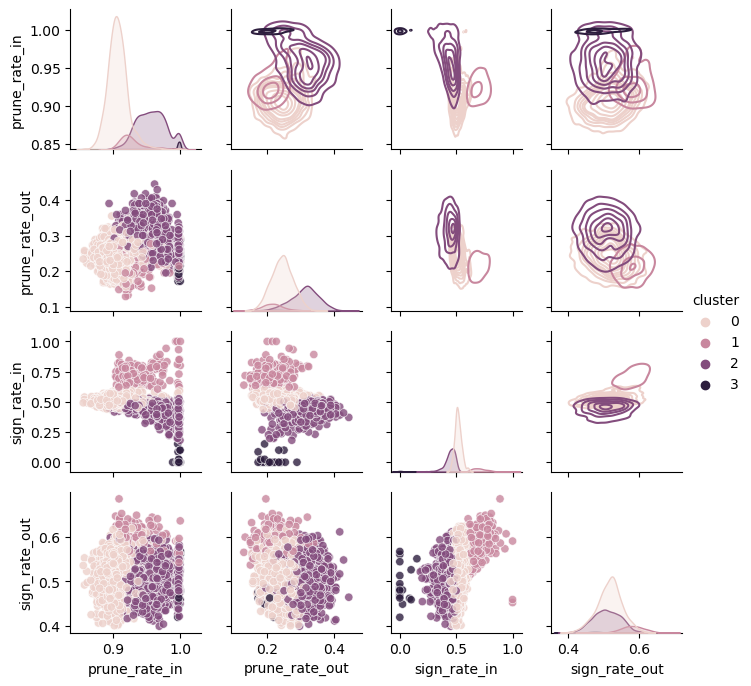

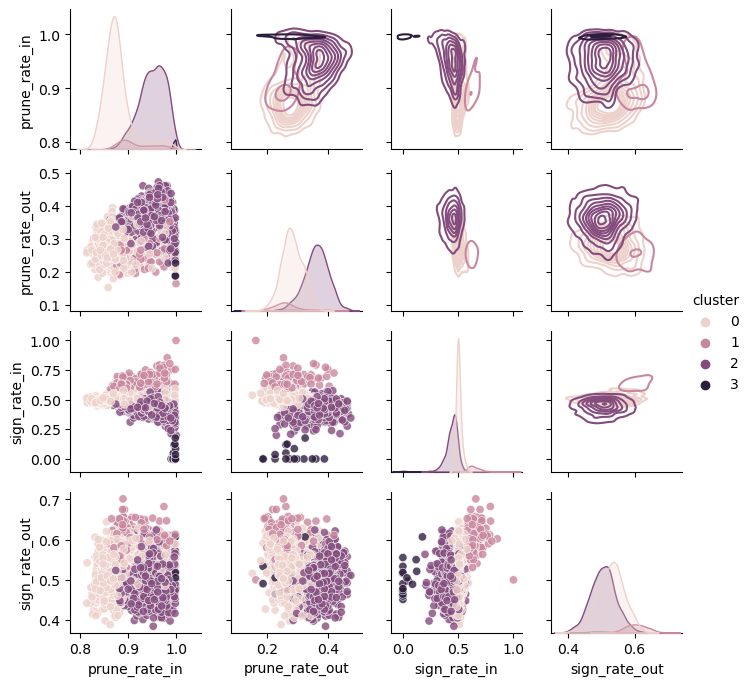

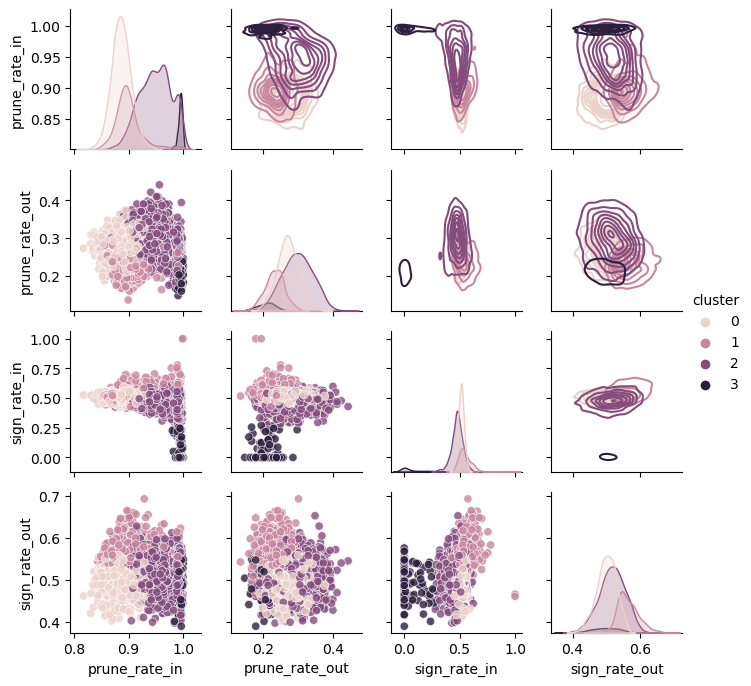

In [8]:
def store_clustered_sign_distr(dataset_names, layer, n_wts, n_clusters):

    for d_name in dataset_names:

        # get the collective sign distributions and cluster them
        coll_sign_distr = get_collective_sign_distr(n_wts, f"{d_name}_IMP",layer)
        clustered_sign_distr = cluster_sign_distr(coll_sign_distr, n_clusters=n_clusters, algorithm=AgglomerativeClustering)

        # relabel tha cluster uniformly
        labels = clustered_sign_distr[["cluster"]]
        copy_labels = copy.copy(labels)
        if d_name == "CINIC":
            copy_labels[labels["cluster"] == 0] = 2 # make 0 2
            copy_labels[labels["cluster"] == 1] = 0 # make 1 0
            copy_labels[labels["cluster"] == 2] = 1 # make 2 1
        elif d_name == "SVHN":
            copy_labels[labels["cluster"] == 0] = 2# make 0 2
            copy_labels[labels["cluster"] == 1] = 3 # make 1 3
            copy_labels[labels["cluster"] == 2] = 1 # make 2 1
            copy_labels[labels["cluster"] == 3] = 0 # make 3 0
        clustered_sign_distr["cluster"] = copy_labels

        # save the dataframe
        clustered_sign_distr.to_csv(f'5b Clusters/clustered_sign_distr_{d_name}_dense1.csv', index=False)

        # store the clustered scatterplot
        g = sns.PairGrid(clustered_sign_distr, hue="cluster", height=1.75)
        g.map_lower(sns.scatterplot,alpha = 0.8)
        g.add_legend()
        g.map_upper(sns.kdeplot)
        g.map_diag(sns.kdeplot, fill=True)
        g.savefig(f"5b Clusters/clustered({n_clusters})_coll_sign_distr_{d_name}_{layer}.png")

store_clustered_sign_distr(["CIFAR","CINIC","SVHN"], "dense1", 15, 4)

## Cluster Statistics

Collecting mean and std for the different dimensions of each cluster as well as the ratio of neurons belonging to the cluster:

In [5]:
variables = ["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out"]
datasets = ["CIFAR_IMP", "CINIC_IMP", "SVHN_IMP"]
n_clusters = [4,4,4]

def get_cluster_stats():
    # make a plot with mean and std of each cluster
    all_cluster_stats = []
    for dataset, n in zip(datasets,n_clusters):
        
        coll_sign_distr = get_collective_sign_distr(15, dataset,"dense1")
        cluster_data = cluster_sign_distr(coll_sign_distr, n_clusters=n, algorithm=AgglomerativeClustering)

        # relabel tha cluster uniformly
        labels = cluster_data[["cluster"]]
        copy_labels = copy.copy(labels)
        if dataset == "CINIC_IMP":
            copy_labels[labels["cluster"] == 0] = 2 # make 0 2
            copy_labels[labels["cluster"] == 1] = 0 # make 1 0
            copy_labels[labels["cluster"] == 2] = 1 # make 2 1
        elif dataset == "SVHN_IMP":
            copy_labels[labels["cluster"] == 0] = 2# make 0 2
            copy_labels[labels["cluster"] == 1] = 3 # make 1 3
            copy_labels[labels["cluster"] == 2] = 1 # make 2 1
            copy_labels[labels["cluster"] == 3] = 0 # make 3 0
        cluster_data["cluster"] = copy_labels

        cluster_stats = pd.DataFrame()
        for cluster in range(n):

            cluster_stats_block = pd.DataFrame()
            for v in variables:

                cluster_data_filtered = cluster_data[cluster_data["cluster"]==cluster]
                #display(cluster_data_filtered)
                cluster_data_filtered = cluster_data_filtered[v]

                cluster_stats_vrow = {}
                cluster_stats_vrow[f"mean_c{cluster}"] = np.mean(cluster_data_filtered)
                cluster_stats_vrow[f"std_c{cluster}"] = np.std(cluster_data_filtered)
                cluster_stats_vrow[f"ratio_c{cluster}"] = len(cluster_data_filtered)/len(cluster_data[v])

                cluster_stats_vrow_df = pd.DataFrame(cluster_stats_vrow, index=[v])
                cluster_stats_block = pd.concat([cluster_stats_block, cluster_stats_vrow_df], axis=0)

            cluster_stats = pd.concat([cluster_stats, cluster_stats_block], axis=1)

        cluster_stats['variable'] = cluster_stats.index
        cluster_stats.to_csv(f"5b Clusters/cluster_stats_{dataset.replace('_IMP','')}.csv", index=False)
        all_cluster_stats.append(cluster_stats)

    return all_cluster_stats

#for i, cluster_stats in enumerate(get_cluster_stats()):
#    print(f"Cluster stats for dataset {datasets[i]} with {n_clusters[i]} clusters:")
#    cluster_stats.set_index('variable')
#    display(cluster_stats)

## Observations

Summarizing the properties of the clusters for each dataset:

In [6]:
def get_cluster_obs(all_cluster_stats):

    for i, cluster_stats in enumerate(all_cluster_stats):

        
        cluster_rows = pd.DataFrame()

        # collect all means
        means = cluster_stats[["mean_c0","mean_c1","mean_c2","mean_c3"]]
        means_p_in = list(means.loc["prune_rate_in"])
        means_p_out = list(means.loc["prune_rate_out"])
        means_s_in = list(means.loc["sign_rate_in"])
        means_s_out = list(means.loc["sign_rate_out"])

        for cluster in range(4):
            cluster_obs = {}

            # for prune in and prune out check whether, highest, lowest or medium
            mean_p_in = cluster_stats.loc["prune_rate_in"][f"mean_c{cluster}"]
            if mean_p_in == np.max(means_p_in):
                cluster_obs["prune_rate_in"] = "highest"
            elif mean_p_in == np.min(means_p_in):
                cluster_obs["prune_rate_in"] = "lowest"
            else:
                cluster_obs["prune_rate_in"] = "medium"
            cluster_obs["prune_rate_in"] = cluster_obs["prune_rate_in"] + f"({np.round(mean_p_in,3)})"

            mean_p_out = cluster_stats.loc["prune_rate_out"][f"mean_c{cluster}"]
            if mean_p_out == np.max(means_p_out):
                cluster_obs["prune_rate_out"] = "highest"
            elif mean_p_out == np.min(means_p_out):
                cluster_obs["prune_rate_out"] = "lowest"
            else:
                cluster_obs["prune_rate_out"] = "medium"
            cluster_obs["prune_rate_out"] = cluster_obs["prune_rate_out"] + f"({np.round(mean_p_out,3)})"

            # for sign in and out check whether balanced, positive or negative
            mean_s_in = cluster_stats.loc["sign_rate_in"][f"mean_c{cluster}"]
            if mean_s_in > 0.55:
                cluster_obs["sign_rate_in"] = "positive"
            elif mean_s_in < 0.45:
                cluster_obs["sign_rate_in"] = "negative"
            else:
                cluster_obs["sign_rate_in"] = "balanced"
            cluster_obs["sign_rate_in"] = cluster_obs["sign_rate_in"] + f"({np.round(mean_s_in,3)})"

            mean_s_out = cluster_stats.loc["sign_rate_out"][f"mean_c{cluster}"]
            if mean_s_out > 0.55:
                cluster_obs["sign_rate_out"] = "positive"
            elif mean_s_out < 0.45:
                cluster_obs["sign_rate_out"] = "negative"
            else:
                cluster_obs["sign_rate_out"] = "balanced"
            cluster_obs["sign_rate_out"] = cluster_obs["sign_rate_out"] + f"({np.round(mean_s_out,3)})"

            # enter the ratio of neurons
            cluster_obs["ratio"] = np.round(cluster_stats.loc["prune_rate_in"][f"ratio_c{cluster}"],3)

            # collect rows in dataframe
            cluster_row = pd.DataFrame(cluster_obs, index=[f"cluster_{cluster}"])
            cluster_rows = pd.concat([cluster_rows, cluster_row], axis=0)
            
        cluster_rows.index = ["cluster_0","cluster_1","cluster_2","cluster_3"]
        cluster_rows = cluster_rows.sort_values("ratio",ascending=False)
        print(f"Cluster stats for dataset {datasets[i]} with {n_clusters[i]} clusters:")
        display(cluster_rows)
        print(cluster_rows.to_latex())


get_cluster_obs(get_cluster_stats())

Cluster stats for dataset CIFAR_IMP with 4 clusters:


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.907),medium(0.244),balanced(0.516),balanced(0.517),0.603
cluster_2,medium(0.957),highest(0.312),negative(0.443),balanced(0.509),0.318
cluster_1,medium(0.931),medium(0.216),positive(0.713),positive(0.582),0.072
cluster_3,highest(0.997),lowest(0.214),negative(0.021),balanced(0.49),0.006


\begin{tabular}{lllllr}
\toprule
 & prune_rate_in & prune_rate_out & sign_rate_in & sign_rate_out & ratio \\
\midrule
cluster_0 & lowest(0.907) & medium(0.244) & balanced(0.516) & balanced(0.517) & 0.603000 \\
cluster_2 & medium(0.957) & highest(0.312) & negative(0.443) & balanced(0.509) & 0.318000 \\
cluster_1 & medium(0.931) & medium(0.216) & positive(0.713) & positive(0.582) & 0.072000 \\
cluster_3 & highest(0.997) & lowest(0.214) & negative(0.021) & balanced(0.49) & 0.006000 \\
\bottomrule
\end{tabular}

Cluster stats for dataset CINIC_IMP with 4 clusters:


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_0,lowest(0.879),medium(0.282),balanced(0.505),balanced(0.528),0.498
cluster_2,medium(0.95),highest(0.36),negative(0.443),balanced(0.505),0.447
cluster_1,medium(0.919),lowest(0.265),positive(0.651),positive(0.605),0.051
cluster_3,highest(0.996),medium(0.28),negative(0.035),balanced(0.505),0.005


\begin{tabular}{lllllr}
\toprule
 & prune_rate_in & prune_rate_out & sign_rate_in & sign_rate_out & ratio \\
\midrule
cluster_0 & lowest(0.879) & medium(0.282) & balanced(0.505) & balanced(0.528) & 0.498000 \\
cluster_2 & medium(0.95) & highest(0.36) & negative(0.443) & balanced(0.505) & 0.447000 \\
cluster_1 & medium(0.919) & lowest(0.265) & positive(0.651) & positive(0.605) & 0.051000 \\
cluster_3 & highest(0.996) & medium(0.28) & negative(0.035) & balanced(0.505) & 0.005000 \\
\bottomrule
\end{tabular}

Cluster stats for dataset SVHN_IMP with 4 clusters:


,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,ratio
cluster_2,medium(0.949),highest(0.298),balanced(0.475),balanced(0.517),0.417
cluster_0,lowest(0.886),medium(0.272),balanced(0.511),balanced(0.5),0.370
cluster_1,medium(0.9),medium(0.233),balanced(0.547),positive(0.564),0.181
cluster_3,highest(0.994),lowest(0.21),negative(0.058),balanced(0.496),0.032


\begin{tabular}{lllllr}
\toprule
 & prune_rate_in & prune_rate_out & sign_rate_in & sign_rate_out & ratio \\
\midrule
cluster_2 & medium(0.949) & highest(0.298) & balanced(0.475) & balanced(0.517) & 0.417000 \\
cluster_0 & lowest(0.886) & medium(0.272) & balanced(0.511) & balanced(0.5) & 0.370000 \\
cluster_1 & medium(0.9) & medium(0.233) & balanced(0.547) & positive(0.564) & 0.181000 \\
cluster_3 & highest(0.994) & lowest(0.21) & negative(0.058) & balanced(0.496) & 0.032000 \\
\bottomrule
\end{tabular}

